<div style="display: flex; justify-content: center;">
    <img src="IA/pensandojpg.jpg" style="border-radius: 20px; width: 75%;">
</div>

<small> Imagen creada por IA generativa usando el siguiente pront: 'Dibújame un robot pensativo, apoyado en una mesa.  
 El dibujo no debe ser muy recargado, solo el robot y parte de la mesa.' (Luego editada con paint)<small>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import seaborn as sns
from scipy.stats import ttest_ind 
from scipy import stats
from scipy.stats import f_oneway 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

In [2]:
df_entradas_util_nuevo = pd.read_parquet(r'C:\Users\pepea\Desktop\the_drige\EDA\Dataset\entradas_validas\df_entradas_util.parquet')
df_entradas_util_nuevo.head(5) 
df_con_motivos = df_entradas_util_nuevo.copy()

### La hipótesis a la que trataré de demostrar en este Jupyter es que el motivo de retirada estará bastante  
###  influenciado por si es o no festivo, fin de semana y la hora.

>Para ello, utilizaré la tabla auxiliar de motivos y, empleando los códigos, añadiré el motivo a la tabla principal, eliminando además las columnas innecesarias  
para una correcta visualización.

In [3]:
df_con_motivos.drop(["deposito", "tipoVehiculo","grua", "tipoVia","via","numero", "cp"], axis=1, inplace=True)
df_con_motivos.head(5)

,motivo,turno,Fecha_e,FinDeSema,Festivo,Hora_e
idVehiculo,,,,,,
CO20160101002327,1,Noche,2016-01-01,False,Año Nuevo,00:05:00
CO20160101012710,9,Noche,2016-01-01,False,Año Nuevo,01:14:00
CO20160101031613,44,Noche,2016-01-01,False,Año Nuevo,02:42:00
CO20160101031820,1,Noche,2016-01-01,False,Año Nuevo,02:50:00
CO20160101031435,7,Noche,2016-01-01,False,Año Nuevo,03:05:00


In [4]:
motivos= pd.read_csv(r'C:\Users\pepea\Desktop\the_drige\EDA\Dataset\datos\auxiliares\motivosretirada.csv', encoding="UTF-8", sep=";")
motivos.drop(["Reason","E. Reason"], axis=1, inplace=True) 
motivos['Codigo'] = motivos['Codigo'].astype(float)
motivos.head(5)

,Codigo,Motivo,E. Motivo
0,1.0,Doble Fila,Estacionar en doble fila
1,2.0,Carril Bus,Estacionar en los carriles reservados para la ...
2,3.0,Carga y Descarga,Estacionar en lugares reservados para carga y ...
3,4.0,Paso Peatones,Estacionar sobre zonas destinadas al uso de pe...
4,5.0,Centro Calzada,Estacionar ocupando la calzada


In [5]:
df_con_motivos['motivo'] = df_con_motivos['motivo'].map(motivos.set_index('Codigo')['Motivo'])

In [6]:
df_con_motivos.head(7)

,motivo,turno,Fecha_e,FinDeSema,Festivo,Hora_e
idVehiculo,,,,,,
CO20160101002327,Doble Fila,Noche,2016-01-01,False,Año Nuevo,00:05:00
CO20160101012710,Esquinas,Noche,2016-01-01,False,Año Nuevo,01:14:00
CO20160101031613,R Minusválido,Noche,2016-01-01,False,Año Nuevo,02:42:00
CO20160101031820,Doble Fila,Noche,2016-01-01,False,Año Nuevo,02:50:00
CO20160101031435,Prohibido Placas,Noche,2016-01-01,False,Año Nuevo,03:05:00
CO20160101033909,Paso Carruajes,Noche,2016-01-01,False,Año Nuevo,03:30:00
CO20160101054347,Quemado,Noche,2016-01-01,False,Año Nuevo,05:40:00


La columna 'motivo' es bastante descriptiva, pero en caso de que necesites una explicación, copiando el motivo y metiéndolo en el siguiente código,  
tendrás una breve explicación.

In [38]:
motivo = input("Por favor ingrese un motivo: ")
fila_motivo = motivos[motivos['Motivo'] == motivo]

if not fila_motivo.empty:
    e_motivo = fila_motivo.iloc[0]['E. Motivo']
    codigo = fila_motivo.iloc[0]['Codigo']
    print(f"La explicacion a '{motivo}' es: \n{e_motivo}.")
    print(f"Y su codigo es: {codigo}")
else:
    print("¿Que?...Por favor, copie y pegue.")

La explicacion a 'Asfalto' es: 
Estacionado en zona reservada para la realización de obras de asfaltado de la vía pública.
Y su codigo es: 33.0


In [9]:
total_entradas_df = len(df_con_motivos)
total_entradas_df

316776

In [10]:
conteo_motivos = df_con_motivos['motivo'].value_counts()
conteo_motivos

motivo
Falta de documentación                       63291
Prohibido Placas                             54514
R Minusválido                                21282
Alcoholemia                                  20195
Paso Carruajes                               17859
Acera                                        16298
Sustraído                                    15047
C. Circulación                               13893
Carga y Descarga                             13151
Rodaje                                        9481
Actos públicos                                8192
Mudanzas                                      7572
Accidente                                     7398
Obras                                         6933
Asfalto                                       6846
Otros                                         4970
Centro Calzada                                4020
Esquinas                                      2906
Detención del conductor                       2697
Paso Peatones           

La introducción a la primera hipótesis la haré con una figura de pastel sobre el peso de cada motivo sobre el total de coches retirados de la vía pública.

In [11]:
motivos_resu ={"Falta de documentación" : 63286,
"Prohibido Placas": 54512,
"R Minusválido" :21282,
"Alcoholemia" : 20193,
"Otros": 157504} 
df_motivos_pastel = pd.DataFrame(list(motivos_resu.items()), columns=['Motivo', 'Frecuencia'])
total_frecuencias = df_motivos_pastel['Frecuencia'].sum()
df_motivos_pastel['Porcentaje'] = ((df_motivos_pastel['Frecuencia'] / total_frecuencias) * 100).round(2)
df_motivos_pastel

,Motivo,Frecuencia,Porcentaje
0,Falta de documentación,63286,19.98
1,Prohibido Placas,54512,17.21
2,R Minusválido,21282,6.72
3,Alcoholemia,20193,6.37
4,Otros,157504,49.72


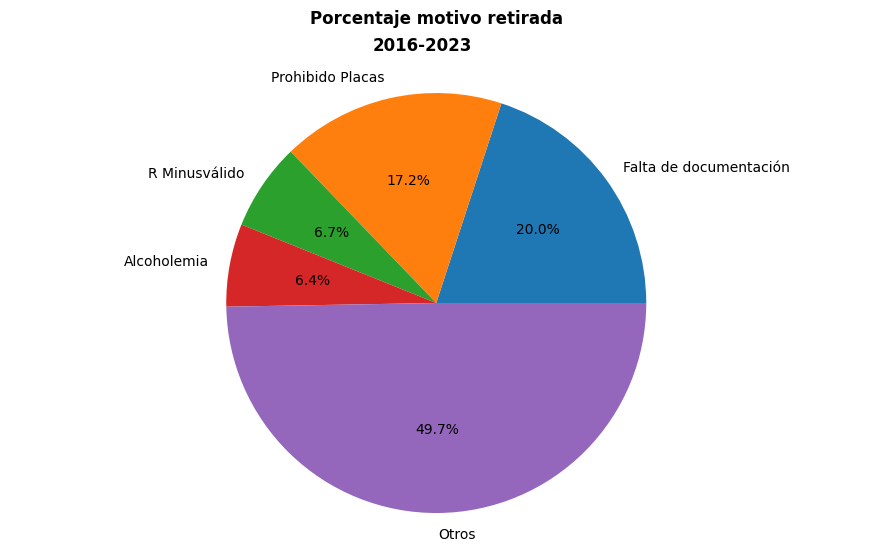

In [12]:
plt.figure(figsize=(11, 6))
plt.pie(df_motivos_pastel['Porcentaje'], labels=df_motivos_pastel['Motivo'], autopct='%1.1f%%', startangle=0)
plt.title('Porcentaje motivo retirada', fontweight='bold', pad=35)
plt.suptitle('2016-2023',fontweight='bold', y=0.94)
plt.axis('equal')  
plt.savefig(R"C:\Users\pepea\Desktop\the_drige\EDA\imagenes\figura_primera_hipotesis\pastel_motivo.png")
plt.show()

Cuatro motivos son responsables de poco más de la mitad de la retirada de vehículos de la vía pública en Madrid  
desde 2016 hasta 2023. Teniendo en cuenta que hay 61 motivos distintos, queda clara la importancia de estos cuatro motivos.  
De hecho, los dos motivos más comunes son responsables de casi el 40% de las retiradas.  

Este es el motivo por el que para introducir la primera hipótesis he incluido este gráfico.

### Primero estudiaré si el motivo de retirada y el hecho de ser o no fin de semana tienen relación.

In [13]:

df_con_motivos['FinDeSema'] = df_con_motivos['FinDeSema'].replace({True: 'Fin de semana', False: 'Entre semana'})
df_con_motivos.head(3)


,motivo,turno,Fecha_e,FinDeSema,Festivo,Hora_e
idVehiculo,,,,,,
CO20160101002327,Doble Fila,Noche,2016-01-01,Entre semana,Año Nuevo,00:05:00
CO20160101012710,Esquinas,Noche,2016-01-01,Entre semana,Año Nuevo,01:14:00
CO20160101031613,R Minusválido,Noche,2016-01-01,Entre semana,Año Nuevo,02:42:00


>Para una mayor claridad, he cambiado "True" por 'Fin de semana' y 'False' por 'Entre semana'.

In [33]:
tabla_de_contingencia_finde = pd.crosstab(df_con_motivos['motivo'], df_con_motivos['FinDeSema'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_de_contingencia_finde)

print("Estadística chi-cuadrado:", chi2)
print("Valor p: {:.10f}".format(p))
print("Grados de libertad:", dof)

Estadística chi-cuadrado: 20674.097740074856
Valor p: 0.0000000000
Grados de libertad: 54


>Dado que 'motivo de retirada' es una variable categórica y ser o no fin de semana es una variable booleana (que también es categórica), la prueba de chi cuadrado es apropiada.  
En este caso, la estadística chi-cuadrado (más de 2000) es considerablemente mayor que los grados de libertad (54) y el valor de p es 0.  
Por lo que podemos rechazar la hipótesis nula y afirmar que efectivamente están relacionados.

In [39]:
tabla_de_contingencia_finde['Porcentaje en fin de semana'] = round((tabla_de_contingencia_finde.iloc[:, 1] / tabla_de_contingencia_finde.sum(axis=1))*100,2)
tabla_de_contingencia_finde = tabla_de_contingencia_finde.sort_values(by='Porcentaje en fin de semana', ascending=False)
tabla_de_contingencia_finde.head(5)

FinDeSema,Entre semana,Fin de semana,Porcentaje en fin de semana
motivo,,,
Alcoholemia,9192,11003,54.34
Actos públicos,5087,3105,37.73
Drogas,885,525,36.30
Carril Bus,259,145,33.17
No adoptar las medidas necesarias,867,430,32.35


>En la tabla anterior muestro cuántos vehículos se retiraron en fin de semana, cuántos se retiraron entre semana, y el porcentaje de retirada en fin de semana,  
según cada motivo de retirada. Teniendo en cuenta que fin de semana (sábados y domingos) son el 28.5% de los días del año, aproximadamente,    
examinando la tabla se puede intuir que hay motivos para rechazar la hipótesis nula. Por ejemplo, más de la mitad de la retirada por alcoholemia fue en fin de semana,  
sin embargo, menos del 1.5% de los 6846 vehículos que se retiraron de alguna zona reservada para la realización de obras de asfaltado fueron en fin de semana.

### Con la siguiente prueba, trataré de demostrar la hipótesis de que ser festivo o no también tiene relación con los distintos motivos para la retirada de los vehículos.

In [42]:
tabla_de_contingencia_festi = pd.crosstab(df_con_motivos['motivo'], df_con_motivos['Festivo'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_de_contingencia_festi)

print("Estadística chi-cuadrado:", chi2)
print("Valor p: {:.1000f}".format(p))
print("Grados de libertad:", dof)

Estadística chi-cuadrado: 4164.208506372668
Valor p: 0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

>Al igual que antes, que comparaba dos variables categóricas (una de ellas booleana), ahora compararé 'motivo de retirada' con la festividad (siendo 'no festivo' una entrada),  
por lo que la prueba de chi cuadrado será la que utilice otra vez. También rechazamos la hipótesis nula, ya que la estadística chi-cuadrado (más de 4100) es considerablemente mayor que los grados de libertad (702) y el valor de p también es 0.


### (Casi) Por último, trataré de demostrar que la hora de retirada está influenciada por el motivo de retirada.

>Ahora compararé la variable categórica "motivo de retirada" con "Minutos", la variable numérica que representa la hora del día a la que cada vehículo fue retirado.  
Es por esto por lo que ahora no haremos chi cuadrado, sino ANOVA.

>>Según chat-gtp, ANOVA (Análisis de Varianza) es una técnica estadística para comparar medias de tres o más grupos. Se aplica a variables numéricas y puede analizar diferencias entre grupos categóricos. Es útil para determinar si estas diferencias son significativas en un contexto de investigación o experimentación.

>Para ello, convertiré la columna 'Hora_e' en 'minutos', una columna en la que la hora del día se transforma en minutos. De esta forma, podemos realizar un ANOVA para ver si el motivo de retirada y la hora a la que se retiró están relacionados.

In [18]:
df_con_motivos['Hora_e_str'] = df_con_motivos['Hora_e'].apply(lambda x: x.strftime('%H:%M')) #Pese a que al hacer '.info()' decía que era de tipo 'object', no dejaba hacer split, así que hagamos esto como paso intermedio.
df_con_motivos['Minutos'] = df_con_motivos['Hora_e_str'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df_con_motivos.drop('Hora_e_str', axis=1, inplace=True)

In [19]:
df_con_motivos.head(3)

,motivo,turno,Fecha_e,FinDeSema,Festivo,Hora_e,Minutos
idVehiculo,,,,,,,
CO20160101002327,Doble Fila,Noche,2016-01-01,Entre semana,Año Nuevo,00:05:00,5
CO20160101012710,Esquinas,Noche,2016-01-01,Entre semana,Año Nuevo,01:14:00,74
CO20160101031613,R Minusválido,Noche,2016-01-01,Entre semana,Año Nuevo,02:42:00,162


In [ ]:
lista_de_motivos= []
distintos_motivos = df_con_motivos['motivo'].unique()
for motivo in distintos_motivos:
    lista_de_motivos.append(motivo)

>De la tabla auxiliar con todos los motivos existentes, 61 motivos distintos, no todos han ocurrido en los años estudiados. Haré una lista con los motivos que han aparecido para poder usarla en el código.

In [20]:
for moti in lista_de_motivos: 
    print(f"    df_con_motivos[df_con_motivos['motivo'] == '{moti}']['Minutos'],")

    df_con_motivos[df_con_motivos['motivo'] == 'Doble Fila']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Esquinas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'R Minusválido']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Prohibido Placas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Paso Carruajes']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Quemado']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Alcoholemia']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Centro Calzada']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Acera']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Accidente']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'C. Circulación']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Obras']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Falta de documentación']['Minutos'],
    df_con_motivos[df_con_motivos

> Para evitar escribirlo todo a mano, he usado este truquito.

In [21]:
anova_primera_hipotesis = f_oneway(
    df_con_motivos[df_con_motivos['motivo'] == 'Doble Fila']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Esquinas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'R Minusválido']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Prohibido Placas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Paso Carruajes']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Quemado']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Alcoholemia']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Centro Calzada']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Acera']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Accidente']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'C. Circulación']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Obras']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Falta de documentación']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Otros']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Disposición del Concejal']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Sustraído']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Precinto']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Paso Peatones']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'No adoptar las medidas necesarias']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Actos públicos']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Rodaje']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Carga y Descarga']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Mudanzas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Sintoma Sustraído']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Alarma sonando']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Poda']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Carril Bus']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Falta de documentación y Garantía de pago']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Detención del conductor']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'O.R.A.']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Placas falsas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Abandono']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'A disposición de Delegación de Gobierno']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Garantía Pago']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Estacionar más de 5 días']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Asfalto']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Sin Infracción']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Disposición de Comisaría']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Estacionar en Arcén']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Custodia (Seguridad)']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'VAMA']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Disposición judicial']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Moto sin Casco']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'L.I.E.']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Estacionar más de 7 días']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Drogas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Deficiencias técnicas']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Enfermedad del conductor']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Bomberos']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Infracción + Presencia Policial']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Seguridad en la vía pública']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Extinción Plaza Aparcamiento']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Implicado en hechos delictivos']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'Vehículo policial']['Minutos'],
    df_con_motivos[df_con_motivos['motivo'] == 'A disposición de la oficina taxi']['Minutos'] 
) 

print("En las pruebas de chi cuadrado anteriores, el valor de p era 0; en esta también lo es.\nValor de p =", anova_primera_hipotesis.pvalue, "\nLo que sugiere una alta significancia, es decir, ambas variables están muy relacionadas.")
print("Además, la estadística F (", anova_primera_hipotesis.statistic, ") es sustancialmente mayor que 1, indicando una\ndiferencia significativa en los motivos de retirada y la hora a la que se retiraron.")


    

En las pruebas de chi cuadrado anteriores, el valor de p era 0; en esta también lo es.
Valor de p = 0.0 
Lo que sugiere una alta significancia, es decir, ambas variables están muy relacionadas.
Además, la estadística F ( 970.6170644312431 ) es sustancialmente mayor que 1, indicando una
diferencia significativa en los motivos de retirada y la hora a la que se retiraron.


Después de realizar la prueba de Análisis de Varianza (ANOVA) y encontrar una relación  
significativa entre los grupos, realizaré la prueba de Tukey como análisis post hoc. El término  
'post hoc' significa 'después de esto' y se refiere a las pruebas o análisis realizados después de la  
prueba de hipótesis inicial para investigar y comprender mejor las diferencias específicas entre los grupos.

In [23]:
tukey_primera_hipotesis = pairwise_tukeyhsd(df_con_motivos['Minutos'], df_con_motivos['motivo'])

In [24]:
print(tukey_primera_hipotesis)

                                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                                       
                  group1                                    group2                   meandiff p-adj    lower      upper   reject
--------------------------------------------------------------------------------------------------------------------------------
  A disposición de Delegación de Gobierno          A disposición de la oficina taxi -190.2792    1.0  -855.3852  474.8268  False
  A disposición de Delegación de Gobierno                                  Abandono  -11.2533    1.0  -112.2822   89.7756  False
  A disposición de Delegación de Gobierno                                 Accidente -188.5288    0.0  -275.0571 -102.0004   True
  A disposición de Delegación de Gobierno                                     Acera -100.5987 0.0028  -186.3816  -14.8159   True
  A disposición de Delegación de Gobierno                            Actos públicos -216.3258    

>Viendo los resultados de la prueba Tukey, vemos que si bien no todos los motivos de retirada de vehículos guardan relación con la hora de retirada, bastantes de ellos sí lo están. Por lo tanto, puedo decir que, en general, el motivo de retirada está relacionado con la hora.

### Por último, haré una gráfica para ver a qué hora se retiran los vehículos según los 4 principales motivos de retirada.

In [26]:
ultima_grafica = df_con_motivos[df_con_motivos['motivo'].isin(["Alcoholemia", "R Minusválido", "Prohibido Placas", "Falta de documentación"])]
columnas_eliminar = ['turno', 'Fecha_e', 'FinDeSema', 'Festivo']
ultima_grafica = ultima_grafica.drop(columnas_eliminar, axis=1)

In [27]:
ultima_grafica['Hora'] = ultima_grafica['Minutos'] // 60
ultima_grafica['Hora'] = ultima_grafica['Hora'].astype(str).str.zfill(2) + ':' + (ultima_grafica['Minutos'] % 60).astype(str).str.zfill(2) 
columnas_eliminar_dos = ["Hora_e", "Minutos"]
ultima_grafica = ultima_grafica.drop(columnas_eliminar_dos, axis=1)


In [28]:
ultima_grafica['Hora_apx'] = ultima_grafica['Hora'].apply(lambda x: ':'.join([str(int(x.split(':')[0]) + 1).zfill(2), '00']) if int(x.split(':')[1]) >= 45 else (':'.join([x.split(':')[0], '30']) if int(x.split(':')[1]) >= 15 else ':'.join(x.split(':')[:1] + ['00'])))

>Con este código he creado, con ayuda de ChatGPT, una columna con las horas resumidas, es decir, se considerará en punto aquellas horas antes de y cuarto,  
se considerará y media aquellas horas entre y cuarto y menos cuarto, y en punto (de la hora siguiente) para después de menos cuarto.  
Con ello, la gráfica se hace mucho más legible.

In [43]:
ultima_grafica.head()


,motivo,Hora,Hora_apx
idVehiculo,,,
CO20160101031613,R Minusválido,02:42,02:30
CO20160101031435,Prohibido Placas,03:05,03:00
CO20160101070514,Alcoholemia,07:00,07:00
ES20160101075109,Alcoholemia,07:49,08:00
ES20160101094735,Alcoholemia,09:46,10:00


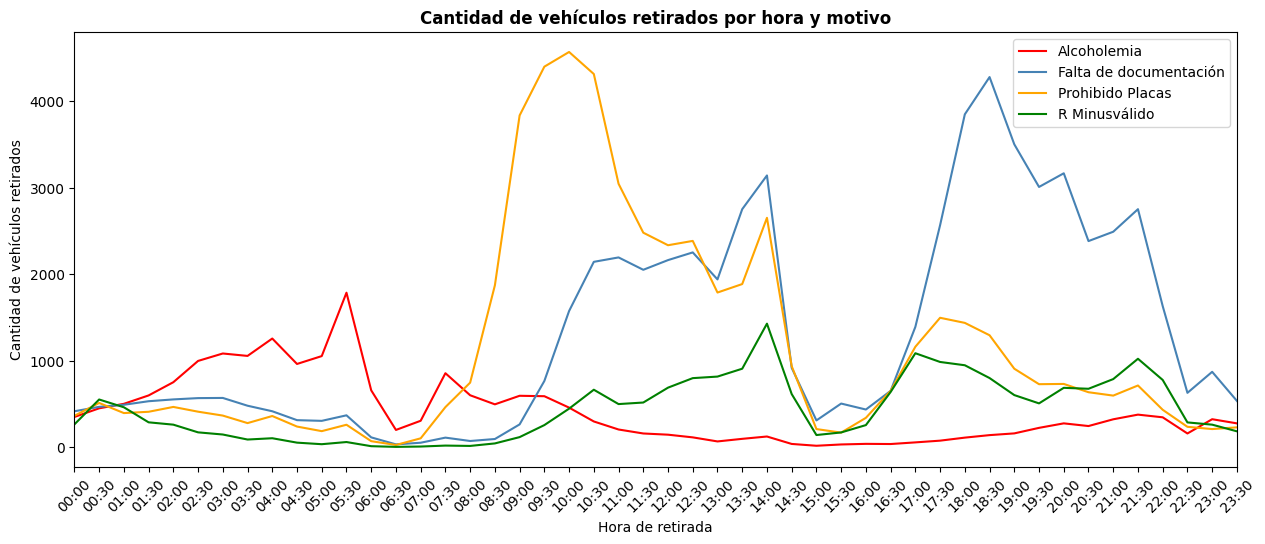

In [53]:
colores = {'Falta de documentación': 'steelblue', 'Alcoholemia': 'red', 'R Minusválido': 'green', 'Prohibido Placas': 'orange'} #Los colores son los mismos que en la figura de pastel.

conteo_vehiculos = ultima_grafica.groupby(['Hora_apx', 'motivo']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(15, 6))  # Ajusta el tamaño de la figura
# Aumenta el área de trazado para evitar el recorte
plt.subplots_adjust(bottom=0.156)

for motivo in conteo_vehiculos.columns:
    ax.plot(conteo_vehiculos.index, conteo_vehiculos[motivo], label=motivo, color=colores.get(motivo, 'black'))

plt.xlabel('Hora de retirada')
plt.ylabel('Cantidad de vehículos retirados')
plt.title('Cantidad de vehículos retirados por hora y motivo', fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.xlim('00:00', '23:30')

# Intenta guardar la figura usando el método de la instancia de la figura
fig.savefig("C:/Users/pepea/Desktop/the_drige/EDA/imagenes/figura_primera_hipotesis/evolu_hora.png")
plt.show()


>En esta gráfica se ve claramente que los motivos (solo se ven los 4 más comunes) no están repartidos por igual a lo largo del día.

<img src="./IA/adios2.jpg" width=600><sub><sup>  

<small>Imagen creada por IA generativa usando el siguiente pront: 'Dibújame un robot pensativo, apoyado en una mesa, diciendo adios con la mano.
 El dibujo no debe ser muy recargado, solo el robot y parte de la mesa.'<small>